In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.layers import Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.python.keras.layers import Dense,Embedding, LSTM, SpatialDropout1D
from tensorflow.python.keras import Sequential
#from keras.optimizers import Adam

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
df = pd.read_csv('filter_20tag_ok.csv')

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
   text = text.lower() # lowercase text
   text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
   text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
   text = text.replace('x', '')
   text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


In [0]:
df_new = df.dropna(subset=['Body'])

In [0]:
df_new.Body_Length.describe()

count     852.000000
mean      466.354460
std       453.561909
min         4.000000
25%       152.000000
50%       303.000000
75%       666.500000
max      2841.000000
Name: Body_Length, dtype: float64

In [0]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(df_new['Body'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

ERROR! Session/line number was not unique in database. History logging moved to new session 60
Found 12870 unique tokens.


In [0]:
X = tokenizer.texts_to_sequences(df_new['Body'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (852, 100)


In [0]:
Y = pd.get_dummies(df_new['y']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (852, 19)


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(766, 100) (766, 19)
(86, 100) (86, 19)


In [0]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.2))

model.add(Dense(19, activation='softmax'))
#optimiser = tf.train.AdamOptimizer(.0001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 100, 100)          500000    
_________________________________________________________________
spatial_dropout1d_22 (Spatia (None, 100, 100)          0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_22 (Dense)             (None, 19)                1235      
Total params: 543,475
Trainable params: 543,475
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
X_train.shape

(766, 100)

In [0]:
Y_train.shape

(766, 19)

In [0]:
epochs = 15
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs,
                    batch_size=batch_size,validation_split=0.1)
                    #callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]

Epoch 1/15
11/11 [==============================] - 2s 205ms/step - loss: 2.9189 - accuracy: 0.2293 - val_loss: 2.8658 - val_accuracy: 0.3247
Epoch 2/15
11/11 [==============================] - 2s 185ms/step - loss: 2.7557 - accuracy: 0.2293 - val_loss: 2.6720 - val_accuracy: 0.2208
Epoch 3/15
11/11 [==============================] - 2s 187ms/step - loss: 2.5417 - accuracy: 0.2554 - val_loss: 2.3559 - val_accuracy: 0.2987
Epoch 4/15
11/11 [==============================] - 2s 184ms/step - loss: 2.2447 - accuracy: 0.3498 - val_loss: 2.1833 - val_accuracy: 0.4805
Epoch 5/15
11/11 [==============================] - 2s 185ms/step - loss: 2.0400 - accuracy: 0.4296 - val_loss: 2.0384 - val_accuracy: 0.4286
Epoch 6/15
11/11 [==============================] - 2s 185ms/step - loss: 1.8998 - accuracy: 0.4601 - val_loss: 1.9011 - val_accuracy: 0.5065
Epoch 7/15
11/11 [==============================] - 2s 189ms/step - loss: 1.7452 - accuracy: 0.5094 - val_loss: 1.7605 - val_accuracy: 0.4935
Epoch 

In [0]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3/3 [==============================] - 0s 12ms/step - loss: 1.3272 - accuracy: 0.5814
Test set
  Loss: 1.327
  Accuracy: 0.581


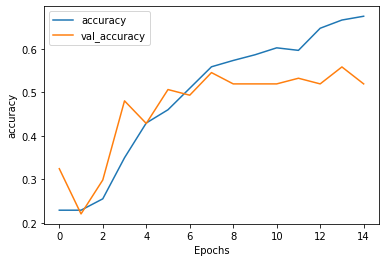

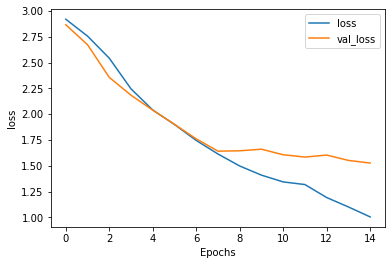

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")